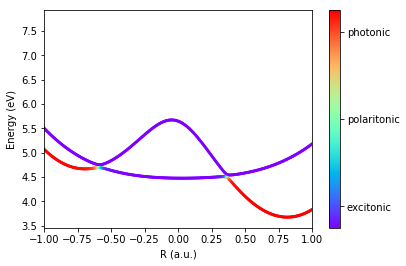

In [11]:
from polaritonic import polaritonic
import numpy as np
#from matplotlib import pyplot as plt
#import matplotlib.animation as animation
import time
import sys
from matplotlib import cm
from matplotlib import rcParams
from matplotlib import pyplot as plt

### initial position
#ri_init = float(sys.argv[1])
ri_init = -0.66156
### initial velocity
##vi_init = float(sys.argv[2])
vi_init = 3.3375e-5
### photonic mode dissipation rate in meV, gamma
#gamp = float(sys.argv[3]) 
gamp = 0.1
### convert to a.u.
gam_diss_np = gamp * 1e-3 / 27.211

### photonic mode energy in eV
#omp = float(sys.argv[4])
omp = 2.45
### convert to a.u.
omc = omp/27.211
### coupling strength in eV
#gp = float(sys.argv[5])
gp = 0.03
gc = gp/27.211

au_to_ps = 2.4188e-17 * 1e12

### get prefix for data file names
#prefix = sys.argv[6]
prefix = "test"
### filename to write nuclear trajectory to
nuc_traj_fn = "Data/" + prefix + '_nuc_traj.txt'
### filename to wrote PES to
pes_fn = "Data/" + prefix + '_pes.txt'
### filename to write electronic/polaritonic dynamics to
ed_fn = "Data/" + prefix + '_electronic.txt'
### filename to write photonic contributions of each state to
pc_fn = "Data/" + prefix + '_photon_contribution.txt'


### Number of updates!
N_time = 1

### N_thresh controls when you start taking the average position
N_thresh = int( N_time / 4)

r_array = []

options = {
        'Number_of_Photons': 1,
        'Photon_Energys': [omc],
        'Coupling_Strengths': [gc], 
        'Photon_Lifetimes': [gam_diss_np],
        'Initial_Position': ri_init,
        'Initial_Velocity': vi_init,
        'Mass': 1009883,
        ### temperature in a.u.
        'Temperature': 0.00095,
        ### friction in a.u.
        'Friction': 0.000011,
        ### specify initial state as a human would, not a computer...
        ### i.e. 1 is the ground state... it will be shifted down by -1 so
        ### that it makes sense to the python index convention
        'Initial_Local_State': 3
        
        }

### instantiate
polt = polaritonic(options)

polt.Transform_L_to_P()
polt.D_polariton = np.zeros((polt.N_basis_states,polt.N_basis_states),dtype=complex)
polt.D_polariton[polt.initial_state,polt.initial_state] = 1+0j
polt.D_local = np.outer(polt.transformation_vecs_L_to_P[:,polt.initial_state], np.conj(polt.transformation_vecs_L_to_P[:,polt.initial_state])) 

polt.Transform_L_to_P()

rlist = np.linspace(-1.5, 1.5, 500)
PES = np.zeros((len(rlist),polt.N_basis_states))
CES = np.zeros((len(rlist),polt.N_basis_states))

### Get PES of polaritonic system and write to file pes_fn
#pes_file = open(pes_fn, "w")
#pc_file = open(pc_fn, "w")
for r in range(0,len(rlist)):
    wr_str = "\n"
    pc_str = "\n"
    polt.R = rlist[r]
    wr_str = wr_str + str(polt.R) + " "
    pc_str = pc_str + str(polt.R) + " "
    polt.H_e()
    polt.H_total = np.copy(polt.H_electronic + polt.H_photonic + polt.H_interaction)
    polt.Transform_L_to_P()
    #polt.D_local = np.outer(polt.transformation_vecs_L_to_P[:,polt.initial_state], np.conj(polt.transformation_vecs_L_to_P[:,polt.initial_state]))
    #print("TV")
    #print(polt.transformation_vecs_L_to_P)
    
    ### get energies and photonic contributions to a given surface
    
    for i in range(0,polt.N_basis_states):
        PES[r,i] = polt.polariton_energies[i]
        polt.D_local = np.outer(polt.transformation_vecs_L_to_P[:,i], 
                                np.conj(polt.transformation_vecs_L_to_P[:,i]))
        #wr_str = wr_str + str(polt.polariton_energies[i]) + " "
        
        ### loop over all photon indices in basis states
        pc = 0
        for j in range(1,polt.NPhoton+1):
            #print(polt.R,i,j,polt.local_basis[i,:])
            if polt.local_basis[i,j]==1:
                #print("now",polt.R,i,j,polt.local_basis[i,j], polt.transformation_vecs_L_to_P[j,i])
                pc = pc + np.real(polt.D_local[i,i])
                #print("nn",pc)
            #pc_str = pc_str + str(pc) + " "
        CES[r,i] = pc
            
            
#    pes_file.write(wr_str)
#    pc_file.write(pc_str)

### Close PES file
#pes_file.close()
#pc_file.close()
fig, ax = plt.subplots()
cm = plt.cm.get_cmap('rainbow')
im = ax.scatter(rlist, 27.211*PES[:,2], c=CES[:,2], cmap=cm, s=4) # rlist, 27.211*PPES[:,1], c=LP_p, cmap=cm )
im = ax.scatter(rlist, 27.211*PES[:,1], c=CES[:,1], cmap=cm, s=4)
cbar = fig.colorbar(im, ticks=[0.1, 0.5, 0.9])
cbar.ax.set_yticklabels(['excitonic', 'polaritonic', 'photonic'])
plt.xlim(-1.,1.)
#plt.ylim(3.5,6.)
plt.xlabel("R (a.u.)")
plt.ylabel("Energy (eV)")
#plt.savefig(filename)
plt.show()

